In [23]:
import os 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [24]:
def agg_time(df):
    times = []
    for index, row in df.iterrows():
        times.append(f"{str(row['year']).split('.')[0]}-{str(row['month']).split('.')[0]}-{str(row['day']).split('.')[0]} {str(row['hour']).split('.')[0]}:{str(row['minute']).split('.')[0]}:00")

    df['time (PST)'] = pd.to_datetime(times)
    df = df.sort_values(by='time (PST)', ascending=True)
    df.drop(['year', 'month', 'day', 'hour', 'minute'], axis=1, inplace=True)

    return df

def subset_summer(df):
    df.set_index('time (PST)', inplace=True)
    df = df[df.index.month.isin([5,6,7,8,9])]
    df.reset_index(inplace=True)

    return df

## Data QC 

In [25]:
#### Specify Arguments ###
# Source data paths
src_dir = '/Users/patmccornack/Documents/ucsb_fog_project/SCI_Fog_Project_Repo/data/01_raw/met_station/still-lab/'
src_fname = 'upem-2005-2010.csv'
src_fpath = os.path.join(src_dir, src_fname)

# Out paths
outdir = '/Users/patmccornack/Documents/ucsb_fog_project/SCI_Fog_Project_Repo/data/02_clean/'
out_fname = 'upem-clean-2005-2010.csv'
out_fpath = os.path.join(outdir, out_fname)

# Define variables
var_dict = {
    'year' : 'Year',
    'month' : 'Month',
    'day' : 'Day',
    'hour' : 'Hour',
    'minute' : 'Minute',
    'fog' :'Fog_Vol_mL',
    'air temperature (C)' : 'AirTC_Avg',
    'relative humidity (%)' : 'RH_Avg',
    'wind speed (m/s)' : 'WS_ms_Avg',
    'wind gust (m/s)' : 'WS_ms_Max',
    'wind direction (deg)' : 'WS_ms_WVc(2)',  # Not certain this is wind dir - see distribution
    'rain (mm)' : 'Rain_Converted_mm',  # Unsure about units
    'solar radiation (kwm2)' :'SlrkW_Avg'
}

# Fog tip value
fog_tip_v = 3.7253

# Options
process_time = True
summer_subset = True

In [26]:
#### Read in and prepare data ####
df = pd.read_csv(src_fpath)
df = df[list(var_dict.values())]
df.columns = list(var_dict.keys())

# Create fog tip var
df['fog tips'] = df['fog'] / fog_tip_v

# Create single datetime column
if process_time == True:
    df = agg_time(df)
    
# Subset to summer months
if summer_subset == True:
    df = subset_summer(df)

df.head(3)

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),solar radiation (kwm2),fog tips
0,2005-09-15 15:15:00,NaN,15.98,74.25,2.309,3.180,240.6,NaN,NaN,NaN
1,2005-09-15 15:30:00,NaN,15.55,75.94,2.649,3.481,245.7,NaN,NaN,NaN
2,2005-09-15 15:45:00,NaN,15.27,77.03,2.896,3.490,249.4,NaN,NaN,NaN


### Missing Values
Observations:
1. Around 12k fog observations are missing. 
2. The same number of rain observations are missing. 
3. A small number of solar radiation observations are missing. 
4. The observations span a really short period of time - 4 months from 09-2015 to 01-2006.

Actions:
1. Drop all missing fog observations.

Notes: 
- Dropping all fog observations also dropped other missing observations. 


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49994 entries, 0 to 49993
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   time (PST)              49994 non-null  datetime64[ns]
 1   fog                     48519 non-null  float64       
 2   air temperature (C)     49994 non-null  float64       
 3   relative humidity (%)   49994 non-null  float64       
 4   wind speed (m/s)        49994 non-null  float64       
 5   wind gust (m/s)         49994 non-null  float64       
 6   wind direction (deg)    49994 non-null  float64       
 7   rain (mm)               48519 non-null  float64       
 8   solar radiation (kwm2)  48519 non-null  float64       
 9   fog tips                48519 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 3.8 MB


In [28]:
# When are values missing? 
missing = df.loc[df.isna().any(axis=1)]
pd.to_datetime(missing['time (PST)']).describe()

count                             1475
mean     2005-09-23 07:29:59.999999872
min                2005-09-15 15:15:00
25%                2005-09-19 11:22:30
50%                2005-09-23 07:30:00
75%                2005-09-27 03:37:30
max                2005-09-30 23:45:00
Name: time (PST), dtype: object

In [29]:
df.dropna(subset='fog', inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 48519 entries, 1475 to 49993
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   time (PST)              48519 non-null  datetime64[ns]
 1   fog                     48519 non-null  float64       
 2   air temperature (C)     48519 non-null  float64       
 3   relative humidity (%)   48519 non-null  float64       
 4   wind speed (m/s)        48519 non-null  float64       
 5   wind gust (m/s)         48519 non-null  float64       
 6   wind direction (deg)    48519 non-null  float64       
 7   rain (mm)               48519 non-null  float64       
 8   solar radiation (kwm2)  48519 non-null  float64       
 9   fog tips                48519 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 4.1 MB


### Univariate Distributions

Check boxplots of each variable to assess data quality.

Observations:
1. Relative humidity is typically high at the site. 
2. Wind typically comes from the northwest, but has a higher spread than pozo.  
3. Most fog observations are 0 - this skews the distribution.
4. There's a wind direction value of over 360

Actions
1. Remove the observation where wind direction > 360

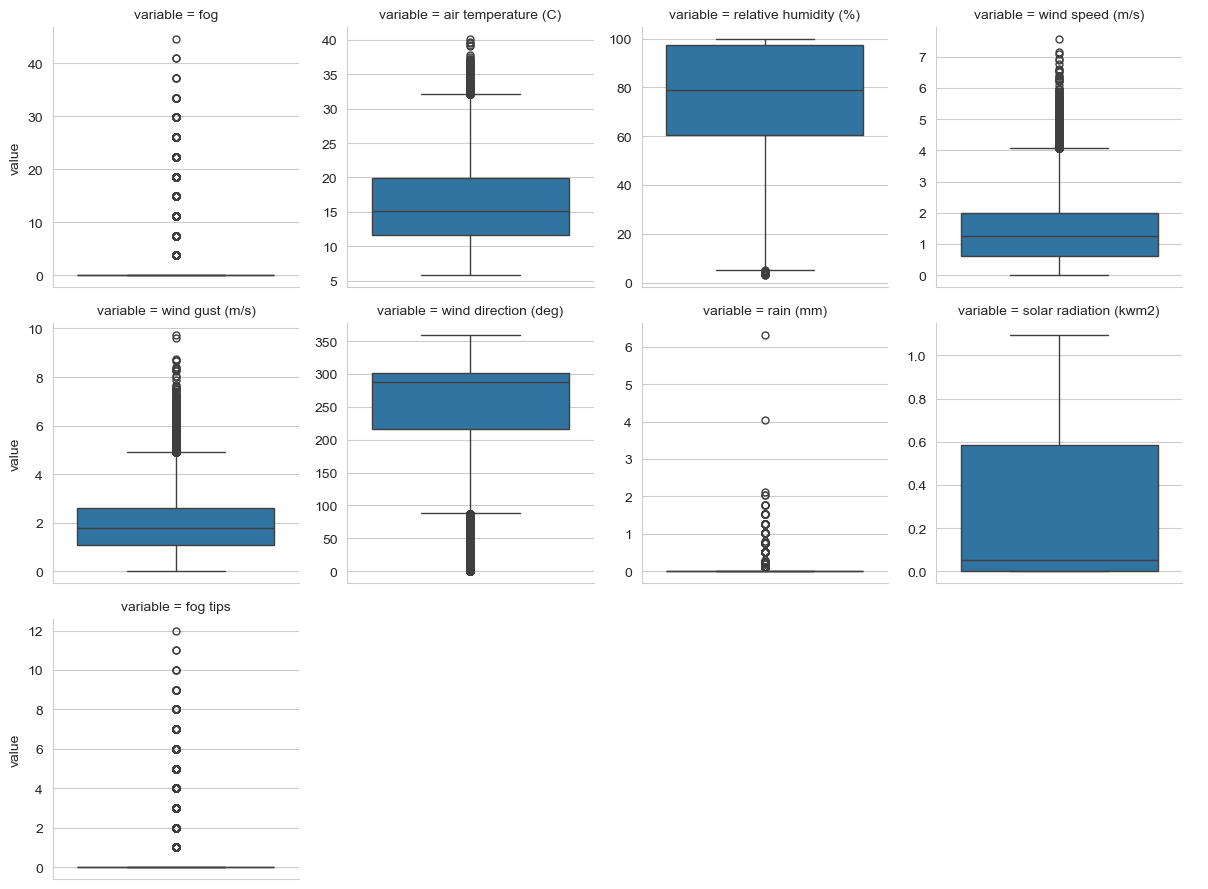

In [30]:
#### Quick plot of distributions ####
# Create long form data
value_col = df.columns.drop(['time (PST)']).tolist()
df_long = pd.melt(df, id_vars=['time (PST)'], value_vars=value_col)

# Plot boxplots
sns.catplot(data=df_long, kind='box', col='variable', y='value',
            sharey=False, height=3, col_wrap=4)
plt.show()


In [31]:
#### Check the actual values ####
df.describe()

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),solar radiation (kwm2),fog tips
count,48519,48519.000000,48519.000000,48519.000000,48519.000000,48519.000000,48519.000000,48519.000000,48519.000000,48519.000000
mean,2008-03-03 23:52:33.496568320,0.494466,16.202308,74.666106,1.414985,1.943983,248.772217,0.004444,0.278142,0.132732
min,2006-05-01 00:00:00,0.000000,5.797000,3.014000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006-09-29 12:52:30,0.000000,11.690000,60.520000,0.614000,1.060000,216.200000,0.000000,0.000000,0.000000
50%,2008-06-23 07:00:00,0.000000,15.150000,79.070000,1.251000,1.777000,287.400000,0.000000,0.053000,0.000000
75%,2009-05-27 15:22:30,0.000000,19.860000,97.500000,1.995000,2.602000,301.800000,0.000000,0.585000,0.000000
max,2009-09-30 23:45:00,44.704000,40.180000,100.000000,7.583000,9.750000,360.000000,6.325000,1.097000,12.000107
std,NaN,2.339647,5.722474,24.289544,1.000897,1.141768,85.140259,0.061958,0.346520,0.628042


### Remove wind direction outlier

In [32]:
ind = df.loc[df['wind direction (deg)'] > 360].index
df.drop(ind, axis=0, inplace=True)
df['wind direction (deg)'].describe()

count    48519.000000
mean       248.772217
std         85.140259
min          0.000000
25%        216.200000
50%        287.400000
75%        301.800000
max        360.000000
Name: wind direction (deg), dtype: float64

### Fog Check
Given the focus of further analysis on fog at the site, further check the distribution of fog.

Note that prior knowledge indicates there's bycatch of rain in the winter, which inflates some of the fog measurements. Further analyses typically focus on summer data as that is the most ecologically relevant time period, which negates this issue. 

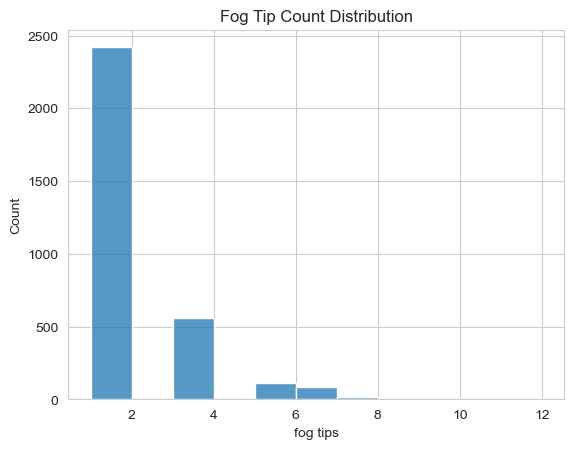

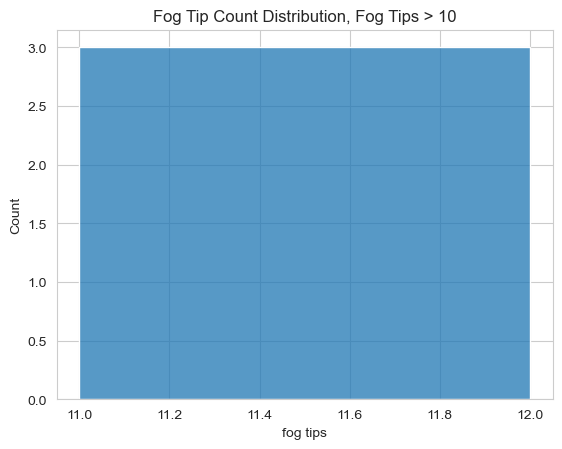

In [33]:
#### Check Distribution of Fog Values ####
sns.histplot(df['fog tips'].loc[df['fog tips']>0],
             binwidth=1)
plt.title('Fog Tip Count Distribution')
plt.show()

# Check right tail of distribution
sns.histplot(df['fog tips'].loc[df['fog tips']>10],
             binwidth=1)
plt.title('Fog Tip Count Distribution, Fog Tips > 10')
plt.show()

### Save out cleaned data

In [34]:
#### Save out cleaned data ####
#df.to_csv(out_fpath)
print(out_fpath)

/Users/patmccornack/Documents/ucsb_fog_project/SCI_Fog_Project_Repo/data/02_clean/upem-clean-2005-2010.csv
